In [15]:
!gdown --id 1QtAJsTjBOf3CnrTzTTqP-nPnHcTc2g9E
!gdown --id 1vlqj4K04uZ7OUcb3LXpzR02I-RAsyToK
!tar xf val.tar

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QtAJsTjBOf3CnrTzTTqP-nPnHcTc2g9E
To: /content/val.tar
100% 6.75G/6.75G [00:30<00:00, 220MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1vlqj4K04uZ7OUcb3LXpzR02I-RAsyToK
To: /content/random_indices_1000_imagenet_hmt.pkl
100% 3.00k/3.00k [00:00<00:00, 4.69MB/s]


In [9]:
!pip install -q torch==1.6.0 torch-dct==0.1.5 timm foolbox

In [10]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.notebook

import torch, torch_dct, timm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from torchvision import transforms
import torchvision.datasets as dset
import foolbox as fb
import torchvision
import torch

In [11]:
PATH_TO_IMAGENET_VAL = "val"
IMAGE_SIZE = 224
BATCH_SIZE = 16 * torch.cuda.device_count()

In [12]:
vit = timm.create_model("vit_base_patch16_224", pretrained=True)
efficient= timm.create_model('tf_efficientnet_b0', pretrained=True)

if torch.cuda.device_count() > 1:
    num_devices = torch.cuda.device_count()
    vit = torch.nn.DataParallel(vit, device_ids=list(range(num_devices)))
    vit = vit.eval().to(DEVICE)
    efficient = torch.nn.DataParallel(efficient, device_ids=list(range(num_devices)))
    efficient = efficient.eval().to(DEVICE)

bounds = (0, 1)
fmodel_vit = fb.PyTorchModel(vit, bounds=bounds)
fmodel_efficient = fb.PyTorchModel(efficient, bounds=bounds)

/usr/local/lib/python3.7/dist-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"
/usr/local/lib/python3.7/dist-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


In [13]:
resnet50 = torchvision.models.resnet50(pretrained=True)
num_devices = torch.cuda.device_count()
resnet50 = torch.nn.DataParallel(resnet50, device_ids=list(range(num_devices)))
resnet50 = resnet50.eval().to(DEVICE)
bounds = (0, 1)
preprocessing = dict(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010], axis=-3) 

fmodel_rn50 = fb.PyTorchModel(resnet50, bounds=bounds, preprocessing=preprocessing)

In [14]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

val_imagenet = dset.ImageFolder(root=PATH_TO_IMAGENET_VAL, transform=transform)
val_idx_subset = pickle.loads(open("random_indices_1000_imagenet_hmt.pkl", "rb").read())

val_sampler = torch.utils.data.SubsetRandomSampler(val_idx_subset)
val_imagenet_loader = torch.utils.data.DataLoader(dataset=val_imagenet, shuffle=False, 
                                 batch_size=BATCH_SIZE, 
                                 sampler=val_sampler, 
                                 num_workers=os.cpu_count(), 
                                 pin_memory=True if DEVICE=="cuda" else False)

print(f"Total ImageNet val size: {len(val_imagenet)}")
print(f"Total batches in the subset: {len(val_imagenet_loader)}")

ValueError: ignored

In [ ]:
attack = fb.attacks.L2DeepFoolAttack(steps=50)
import foolbox.attacks as fa
attack = fa.LinfPGD() 

In [24]:
def launch_deepfool(fmodel):
    deltas = []
    is_advs = []

    for (images, labels) in tqdm.notebook.tqdm(val_imagenet_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        raw, _, is_adv = attack(fmodel, images, labels, epsilons=1e-4)
        raw = raw.detach()
        is_adv = is_adv.detach()
        deltas.append((raw - images).cpu().numpy())
        is_advs.append(is_adv.cpu().numpy())
        
    return np.concatenate(deltas), np.concatenate(is_advs)

In [38]:
def     launch_pgd(fmodel):
    deltas = []
    is_advs = []

    for (images, labels) in tqdm.notebook.tqdm(val_imagenet_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        raw, _, is_adv = attack(fmodel, images, labels, epsilons=1e-4)
        raw = raw.detach()
        is_adv = is_adv.detach()
        deltas.append((raw - images).cpu().numpy())
        is_advs.append(is_adv.cpu().numpy())
        
    return np.concatenate(deltas), np.concatenate(is_advs)

# Deepfool


In [41]:
fmodel_vit

In [11]:
results_vit = launch_deepfool(fmodel_vit)
results_efficient = launch_deepfool(fmodel_efficient)
results_resnet = launch_deepfool(fmodel_rn50)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

# PGD

In [42]:
fmodel_rn50 = fb.PyTorchModel(resnet50, bounds=(0,1), preprocessing=preprocessing)
fmodel_vit = fb.PyTorchModel(vit, bounds=bounds)
fmodel_efficient = fb.PyTorchModel(efficient, bounds=bounds,preprocessing=preprocessing)

results_vit = launch_pgd(fmodel_vit)
results_efficient = launch_pgd(fmodel_efficient)
results_resnet = launch_pgd(fmodel_rn50)


/usr/local/lib/python3.7/dist-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"
/usr/local/lib/python3.7/dist-packages/foolbox/models/pytorch.py:37: UserWarning: The PyTorch model is in training mode and therefore might not be deterministic. Call the eval() method to set it in evaluation mode if this is not intended.
  "The PyTorch model is in training mode and therefore might"


  0%|          | 0/63 [00:00<?, ?it/s]

AssertionError: ignored

In [27]:
np.save("results_vit.npy", results_vit[0])
np.save("results_efficient.npy", results_efficient[0])
np.save("results_rn50.npy", results_resnet[0])

In [28]:
def compute_avg_energy(deltas):
    deltas_dct = torch_dct.dct_2d(torch.from_numpy(deltas)) # Change basis to DCT for example
    return 10*np.log10((deltas_dct ** 2).sum(dim=1).mean(dim=0).numpy()) # Compute average energy on DCT basis
    # log-transform is for better visualization

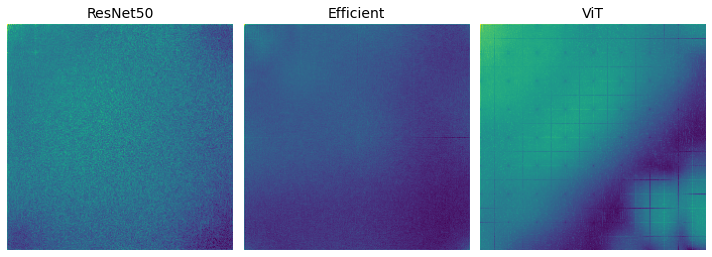

In [32]:
# The dims with the higher energy are those directions with the highest discriminative content
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 10))
[a.axis("off") for a in np.ravel(ax)] 

ax[0].imshow(compute_avg_energy(results_resnet[0]))
ax[1].imshow(compute_avg_energy(results_efficient[0]))
ax[2].imshow(compute_avg_energy(results_vit[0]))

ax[0].set_title("ResNet50", fontsize=14)
ax[1].set_title("Efficient", fontsize=14)
ax[2].set_title("ViT", fontsize=14)

fig.tight_layout()
fig.savefig("disc_regions.png", dpi=300, bbox_inches="tight")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


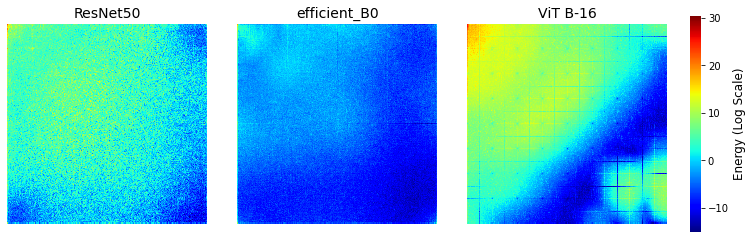

In [31]:
# https://stackoverflow.com/a/42712772/7636462

f,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10, 10))
ax1.get_shared_y_axes().join(ax2,ax3)

g1 = sns.heatmap(compute_avg_energy(results_resnet[0]), cmap="jet",cbar=False, ax=ax1)
g1.set(adjustable='box', aspect='equal')
g1.set_title("ResNet50", fontsize=14)
g1.axis("off")

g2 = sns.heatmap(compute_avg_energy(results_efficient[0]), cmap="jet", cbar=False, ax=ax2)
g2.set(adjustable='box', aspect='equal')
g2.set_title("efficient_B0", fontsize=14)
g2.axis("off")

cbar_ax = f.add_axes([0.99, .35, .015, .3])
g3 = sns.heatmap(compute_avg_energy(results_vit[0]), cmap="jet", ax=ax3, 
                 cbar_ax=cbar_ax,
                 cbar_kws={"label": "Energy (Log Scale)"})
cbar_ax.yaxis.label.set_size(12)
cbar_ax.set
g3.set(adjustable='box', aspect='equal')
g3.set_title("ViT B-16", fontsize=14)
g3.axis("off")

f.tight_layout(pad=3.0)
f.savefig("dct_heatmaps.png", dpi=300, bbox_inches="tight")

In [33]:


transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_imagenet = dset.ImageFolder(root=PATH_TO_IMAGENET_VAL, transform=transform)
val_imagenet_loader = torch.utils.data.DataLoader(dataset=val_imagenet, shuffle=False, 
             batch_size=BATCH_SIZE, 
             sampler=val_sampler, 
             num_workers=os.cpu_count(), 
             pin_memory=True if DEVICE=="cuda" else False)

deltas = []
is_advs = []

for (images, labels) in tqdm.notebook.tqdm(val_imagenet_loader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    raw, _, is_adv = attack(fmodel_rn50, images, labels, epsilons=1e-4)
    raw = raw.detach()
    is_adv = is_adv.detach()
    deltas.append((raw - images).cpu().numpy())
    is_advs.append(is_adv.cpu().numpy())
    
results_rn50 = (np.concatenate(deltas), np.concatenate(is_advs))

  0%|          | 0/63 [00:00<?, ?it/s]

AssertionError: ignored